In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../data/Bank_churn.csv")

In [ ]:
df.head()

In [18]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [6]:
def load_and_preprocess_data(file_path: str, target_column: str) -> pd.DataFrame:
    """
    Load and preprocess the dataset from a CSV file.

    Args:
        file_path (str): Path to the CSV dataset file.
        target_column (str): Name of the target column for churn.

    Returns:
        pd.DataFrame: Processed DataFrame ready for model training.
    """

    # Load the dataset
    if not file_path.endswith('.csv'):
        raise ValueError("Unsupported file type: only CSV files are supported.")
    
    data = pd.read_csv(file_path)

    # Separate features and target variable
    X = data.drop(columns=[target_column])
    y = data[target_column]

    # Handle missing values
    # Strategy: For numeric columns, we can use 'mean', and for categorical, we can use 'most_frequent'
    numeric_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    
    imputer_numeric = SimpleImputer(strategy='mean')
    imputer_categorical = SimpleImputer(strategy='most_frequent')

    X[numeric_features] = imputer_numeric.fit_transform(X[numeric_features])
    X[categorical_features] = imputer_categorical.fit_transform(X[categorical_features])

    # Encode categorical features
    if categorical_features:
        encoder = OneHotEncoder(sparse=False, drop='first')
        X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_features]), columns=encoder.get_feature_names_out(categorical_features))
        X_encoded.index = X.index  # Preserve original index

        # Drop original categorical columns and concatenate the encoded columns
        X = pd.concat([X.drop(columns=categorical_features), X_encoded], axis=1)

    scaler = StandardScaler()
    X[numeric_features] = scaler.fit_transform(X[numeric_features])

    # Combine processed features and target
    processed_data = pd.concat([X, y.reset_index(drop=True)], axis=1)
    return processed_data

In [7]:
file_path = '../data/Bank_churn.csv'  # Adjust the file path as necessary
target_column = 'churn'
processed_data = load_and_preprocess_data(file_path, target_column)
print(processed_data.head())

C:\Program Files\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


   rownumber  customerid  creditscore       age    tenure   balance  \
0  -1.731878   -0.783213    -0.326221  0.293517 -1.041760 -1.225848   
1  -1.731531   -0.606534    -0.440036  0.198164 -1.387538  0.117350   
2  -1.731185   -0.995885    -1.536794  0.293517  1.032908  1.333053   
3  -1.730838    0.144767     0.501521  0.007457 -1.387538 -1.225848   
4  -1.730492    0.652659     2.063884  0.388871 -1.041760  0.785728   

   numofproducts  hascrcard  isactivemember  estimatedsalary  ...  \
0      -0.911583   0.646092        0.970243         0.021886  ...   
1      -0.911583  -1.547768        0.970243         0.216534  ...   
2       2.527057   0.646092       -1.030670         0.240687  ...   
3       0.807737  -1.547768       -1.030670        -0.108918  ...   
4      -0.911583   0.646092        0.970243        -0.365276  ...   

   surname_Zox  surname_Zubarev  surname_Zubareva  surname_Zuev  \
0          0.0              0.0               0.0           0.0   
1          0.0          

In [21]:
def perform_eda(data, top_features=10, max_scatter_plots=20):
    """
    Perform Exploratory Data Analysis on the dataset.

    Args:
        data (pandas.DataFrame): The dataset to perform EDA on.
        top_features (int, optional): The number of top features to display in visualizations. Defaults to 10.
        max_scatter_plots (int, optional): The maximum number of scatter plots to generate. Defaults to 20.
    """

    # Basic overview
    print("Dataset Shape:", data.shape)
    print(data.info())
    print(data.describe(include='all'))

    # Check for missing values
    plt.figure(figsize=(10, 6))
    sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.show()

    # Separate features into numeric and categorical
    numeric_features = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
    categorical_features = data.select_dtypes(include=['object']).columns.tolist()

    # Distribution of top numeric features
    num_numeric_features = min(len(numeric_features), top_features)
    num_rows = math.ceil(num_numeric_features / 3)  # Adjust the number of rows as needed
    plt.figure(figsize=(15, num_rows * 5))  # Adjust the figure size based on the number of rows

    for i, feature in enumerate(numeric_features[:top_features]):
        plt.subplot(num_rows, 3, i + 1)
        sns.histplot(data[feature], bins=30, kde=True)
        plt.title(f'Distribution of {feature}')

    plt.tight_layout()
    plt.show()

    # Correlation matrix for top numeric features
    plt.figure(figsize=(12, 8))
    correlation_matrix = data[numeric_features[:top_features]].corr()
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
    plt.title('Correlation Matrix')
    plt.show()

    # Visualizing relationships between top numeric feature pairs
    num_scatter_plots = min(len(numeric_features) * (len(numeric_features) - 1) // 2, max_scatter_plots)
    scatter_plot_count = 0

    for i in range(len(numeric_features)):
        for j in range(i+1, len(numeric_features)):
            if scatter_plot_count >= num_scatter_plots:
                break

            plt.figure(figsize=(10, 6))
            sns.scatterplot(x=numeric_features[i], y=numeric_features[j], data=data)
            plt.title(f'Relationship between {numeric_features[i]} and {numeric_features[j]}')
            plt.xlabel(numeric_features[i])
            plt.ylabel(numeric_features[j])
            plt.xticks(rotation=45)
            plt.show()
            scatter_plot_count += 1

    # Churn by categorical features
    for feature in categorical_features[:top_features]:
        plt.figure(figsize=(10, 6))
        data[feature].value_counts().plot(kind='bar')
        plt.title(f'Distribution of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

Dataset Shape: (10000, 2945)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 2945 entries, rownumber to churn
dtypes: float64(2944), int64(1)
memory usage: 224.7 MB
None
          rownumber    customerid   creditscore           age        tenure  \
count  1.000000e+04  1.000000e+04  1.000000e+04  1.000000e+04  1.000000e+04   
mean  -9.094947e-17  7.583978e-15 -4.824585e-16  2.318146e-16 -1.078249e-16   
std    1.000050e+00  1.000050e+00  1.000050e+00  1.000050e+00  1.000050e+00   
min   -1.731878e+00 -1.741069e+00 -3.109504e+00 -1.994969e+00 -1.733315e+00   
25%   -8.659388e-01 -8.676501e-01 -6.883586e-01 -6.600185e-01 -6.959818e-01   
50%    0.000000e+00 -2.816100e-03  1.522218e-02 -1.832505e-01 -4.425957e-03   
75%    8.659388e-01  8.659939e-01  6.981094e-01  4.842246e-01  6.871299e-01   
max    1.731878e+00  1.734255e+00  2.063884e+00  5.061197e+00  1.724464e+00   

            balance  numofproducts     hascrcard  isactivemember  \
count  1.00000

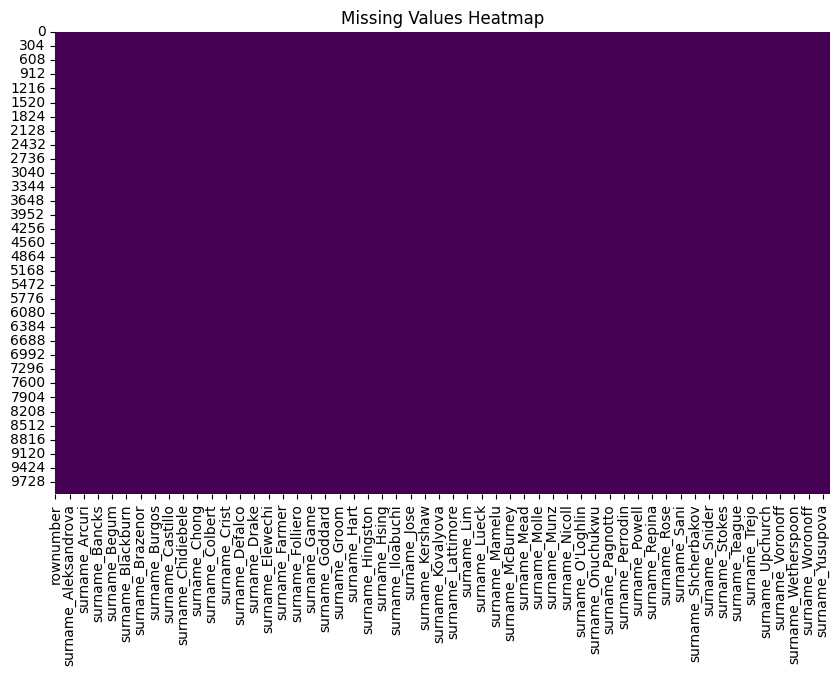

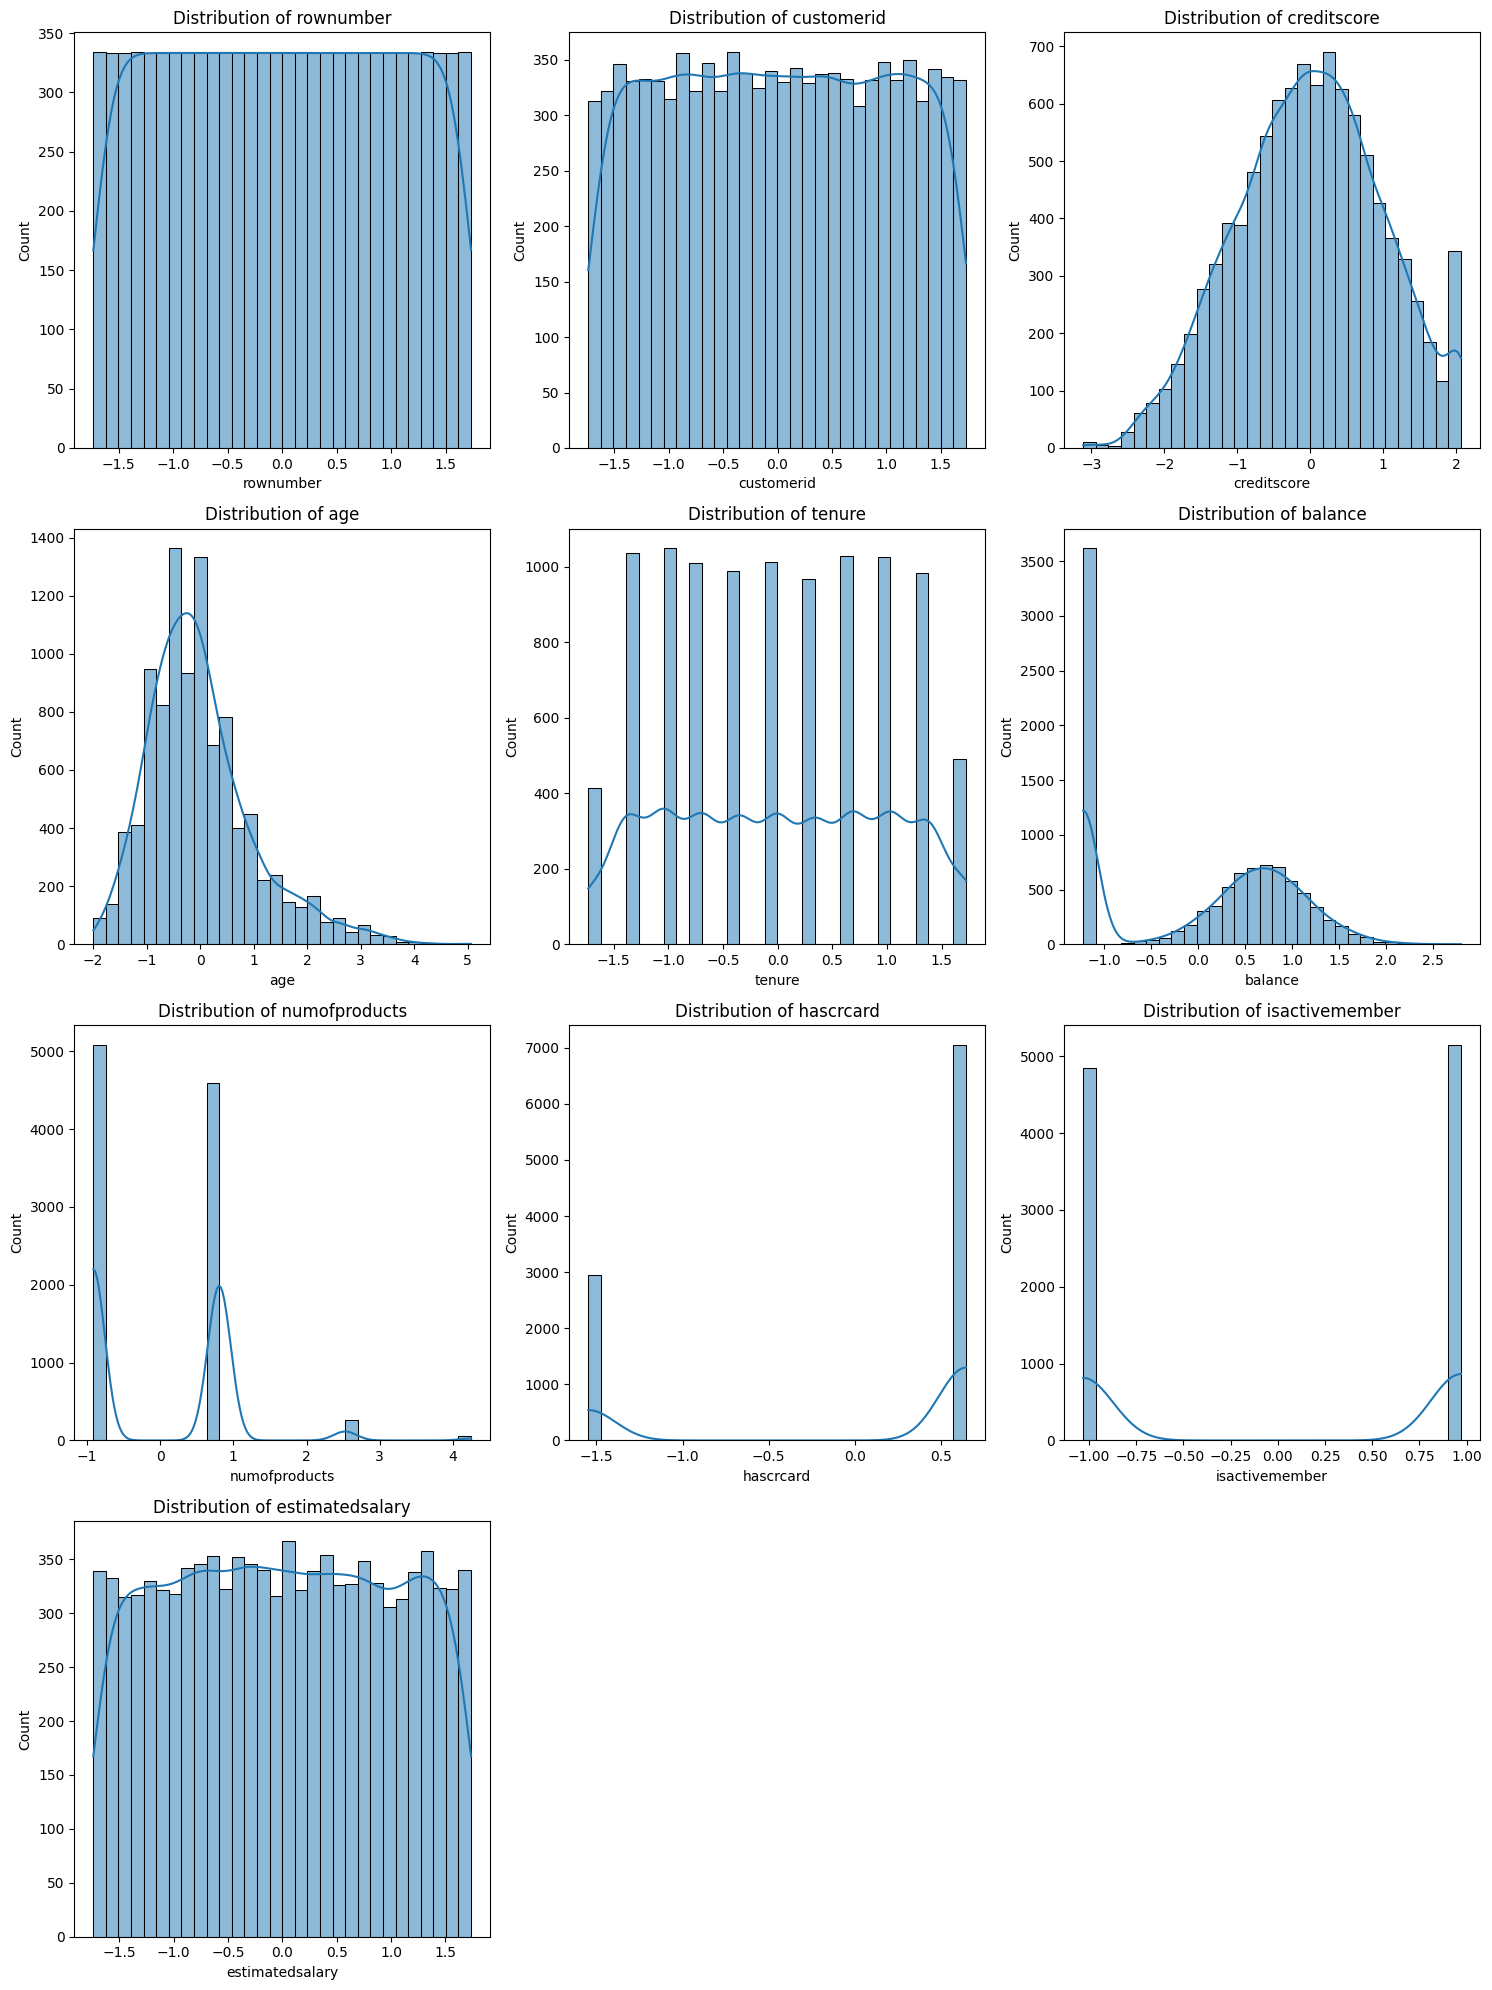

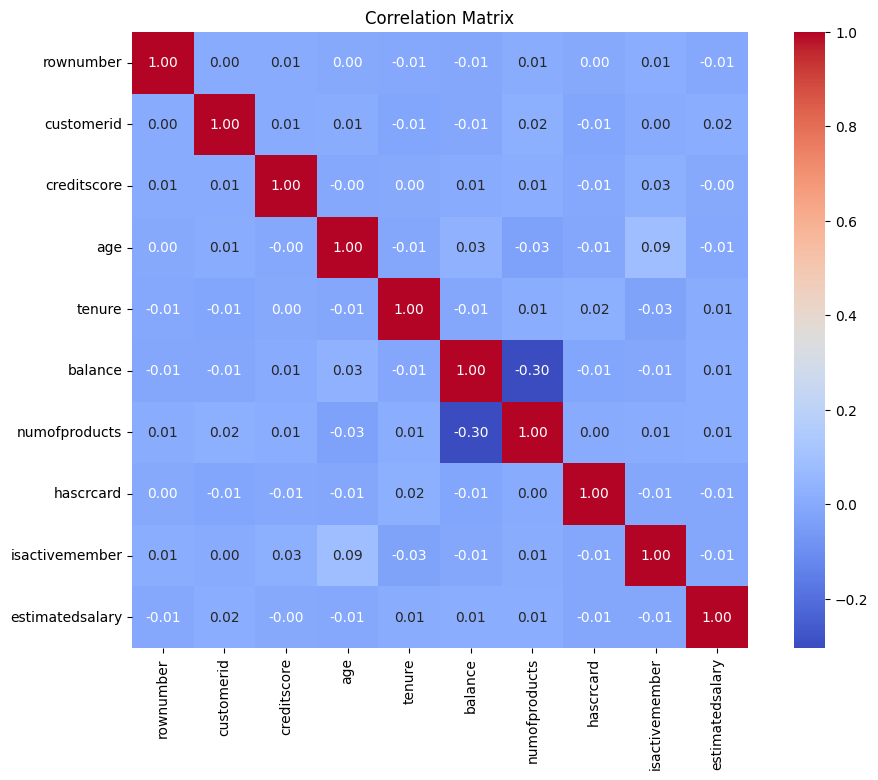

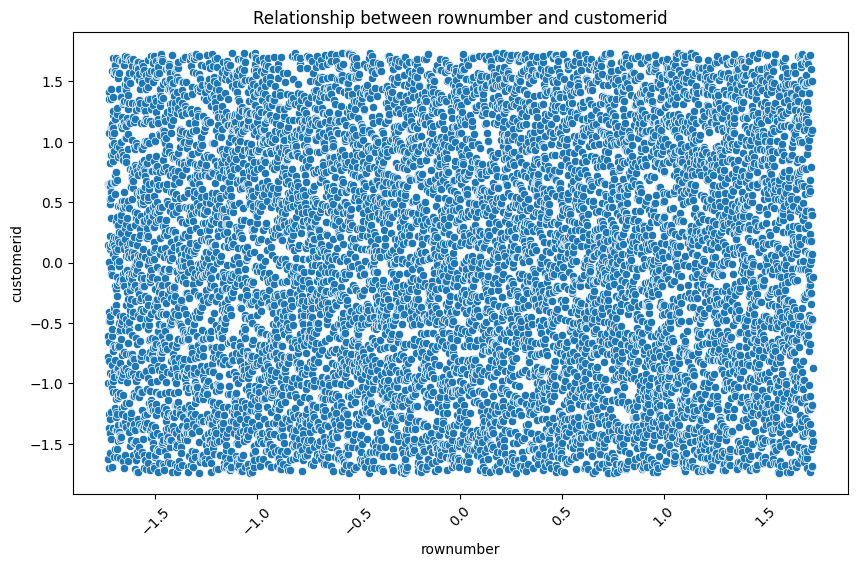

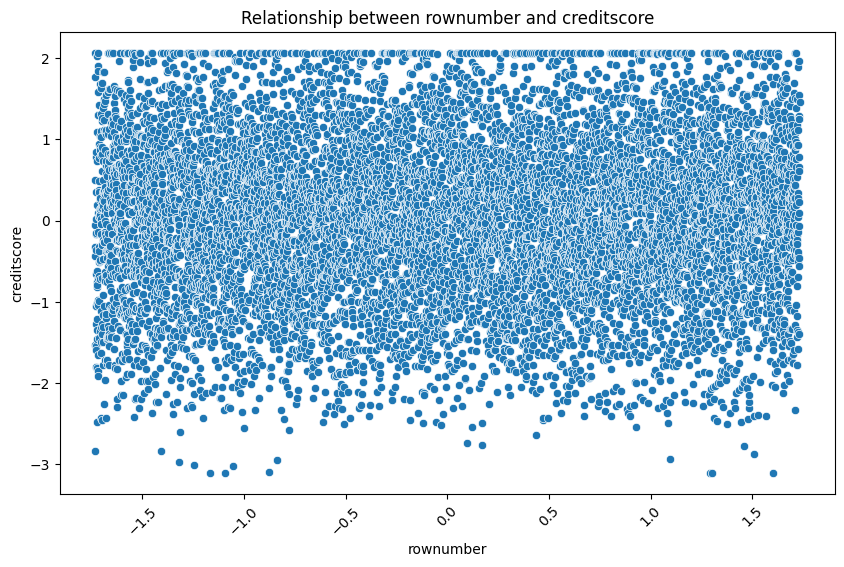

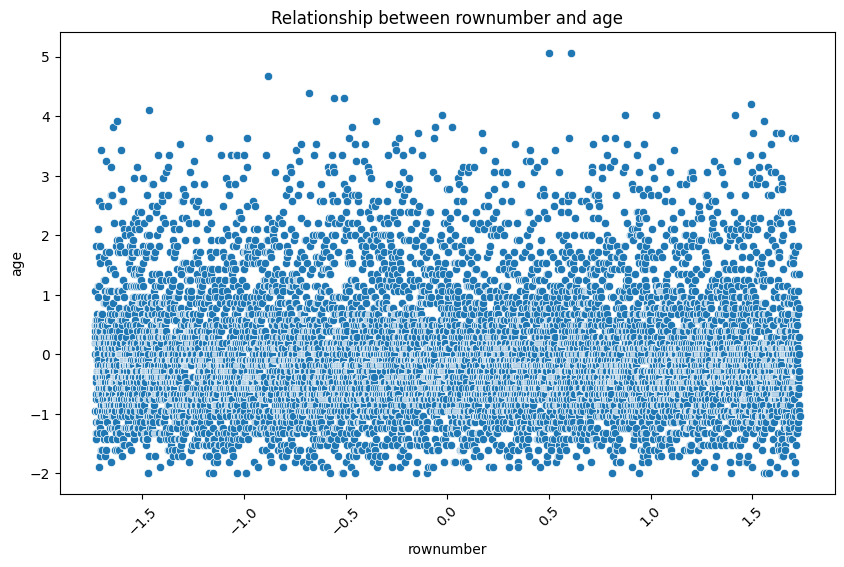

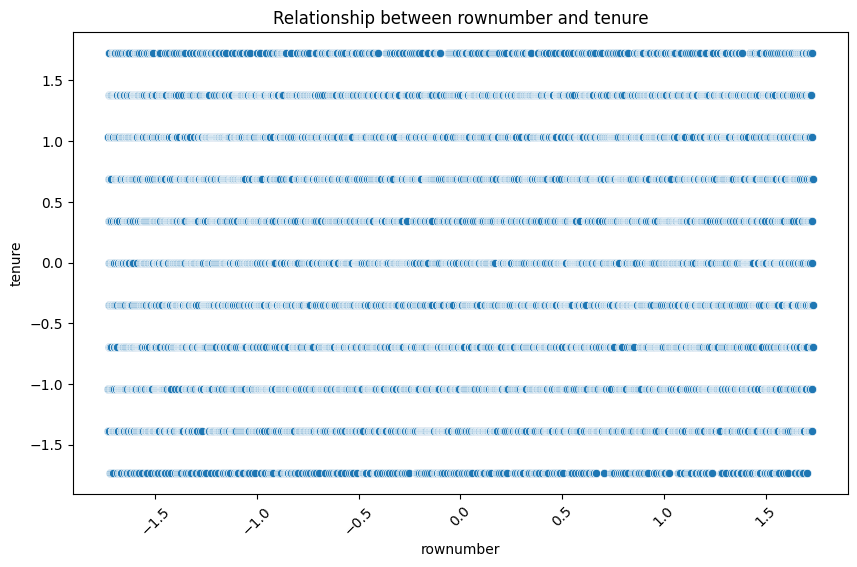

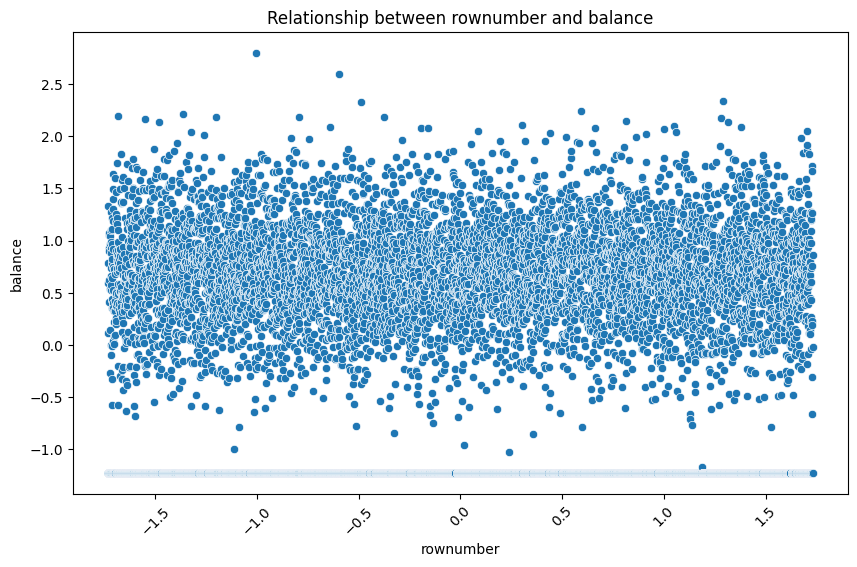

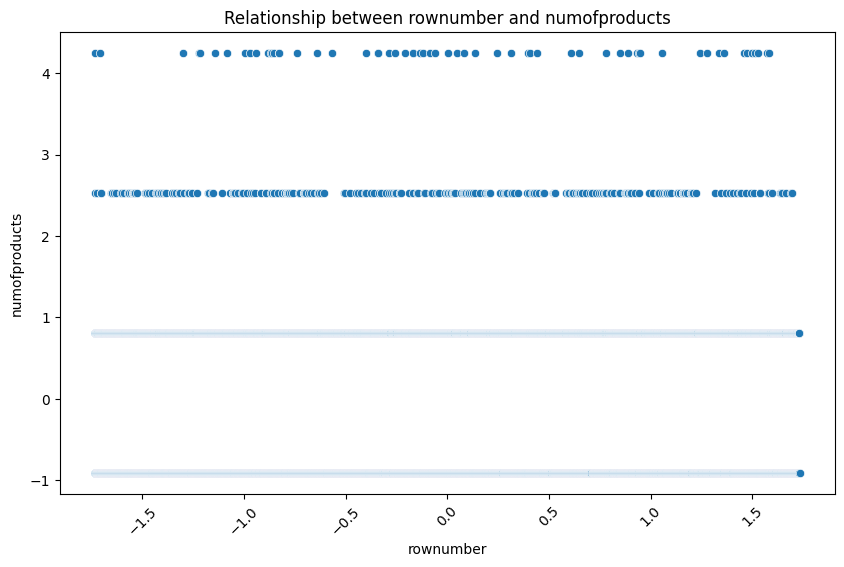

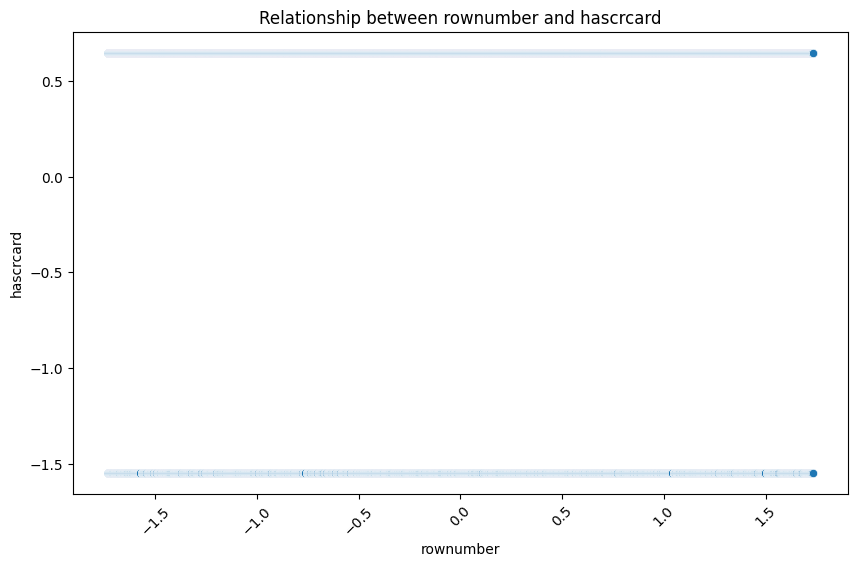

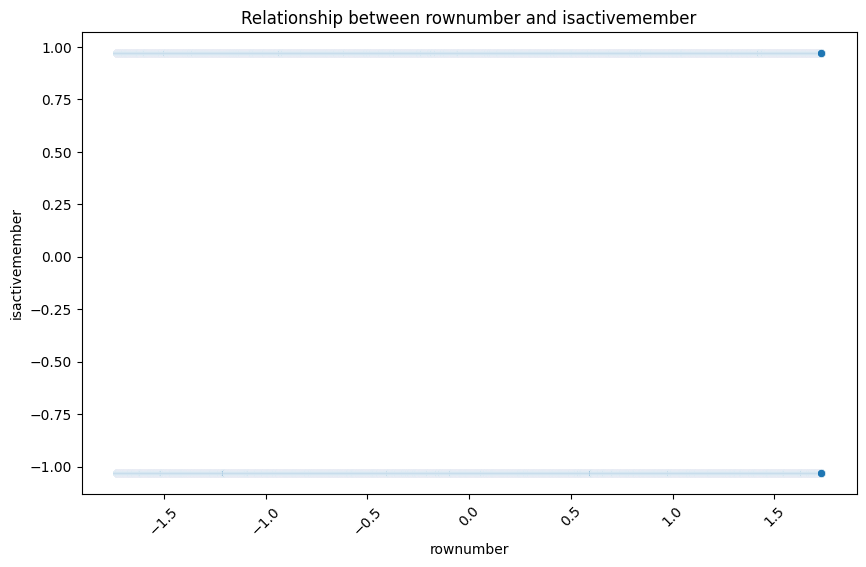

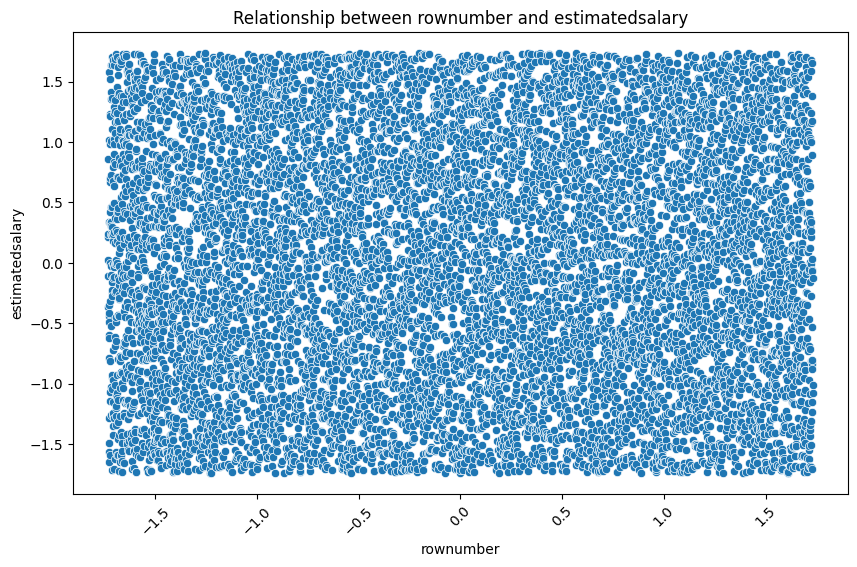

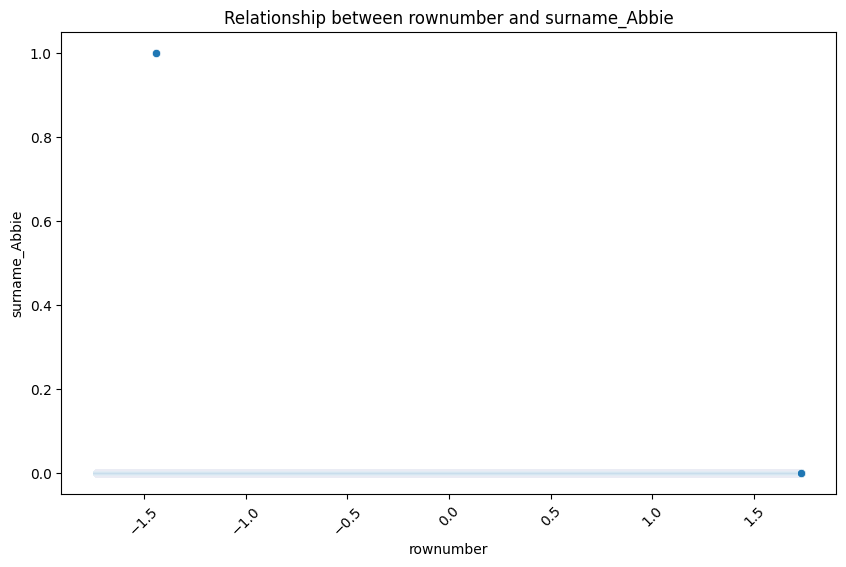

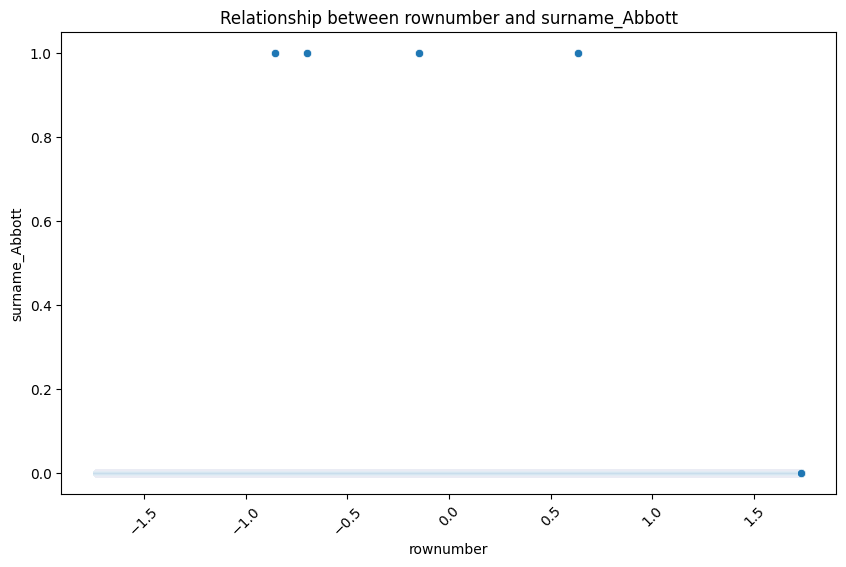

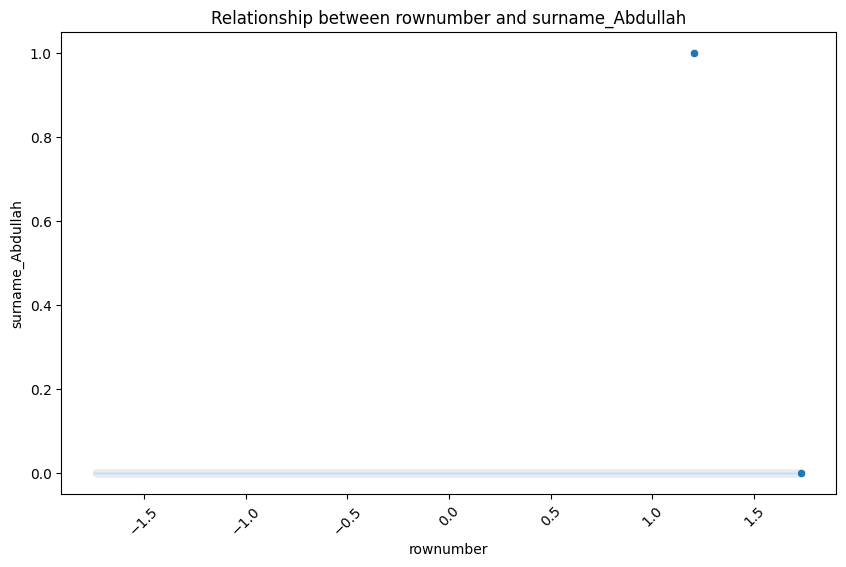

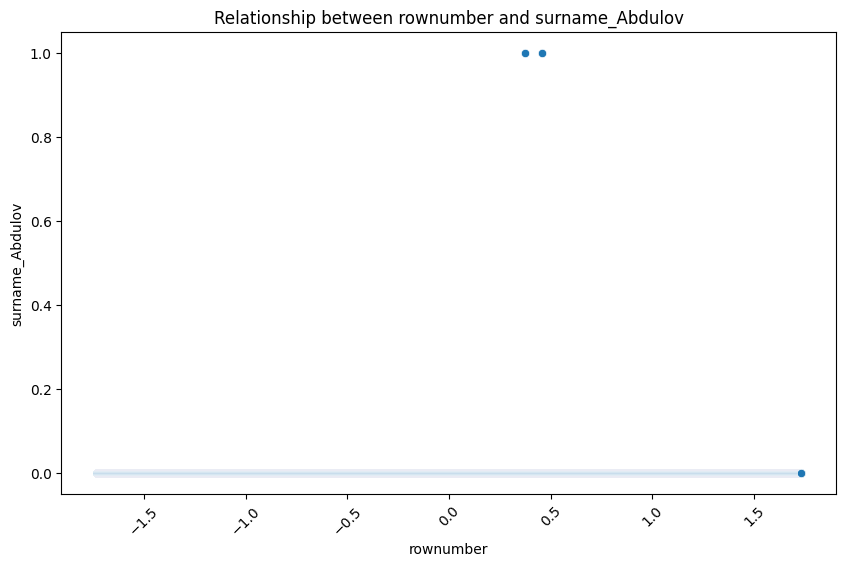

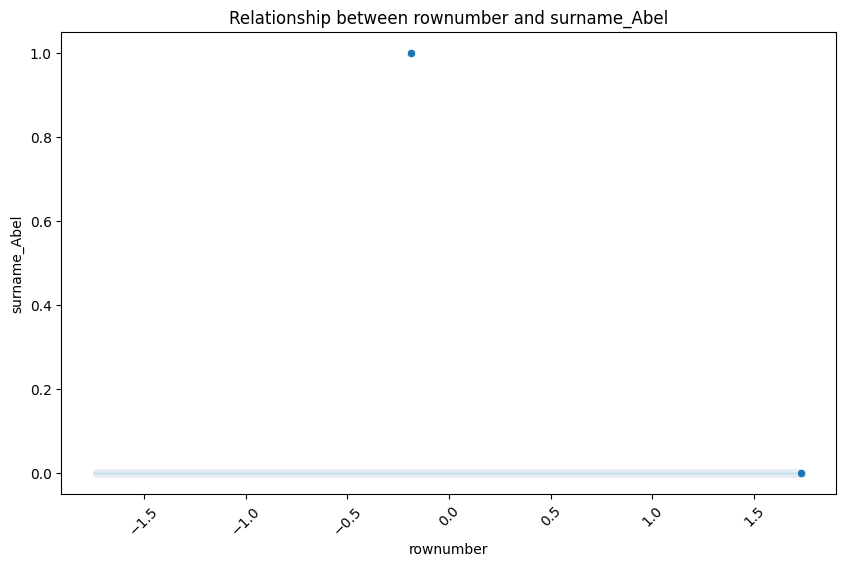

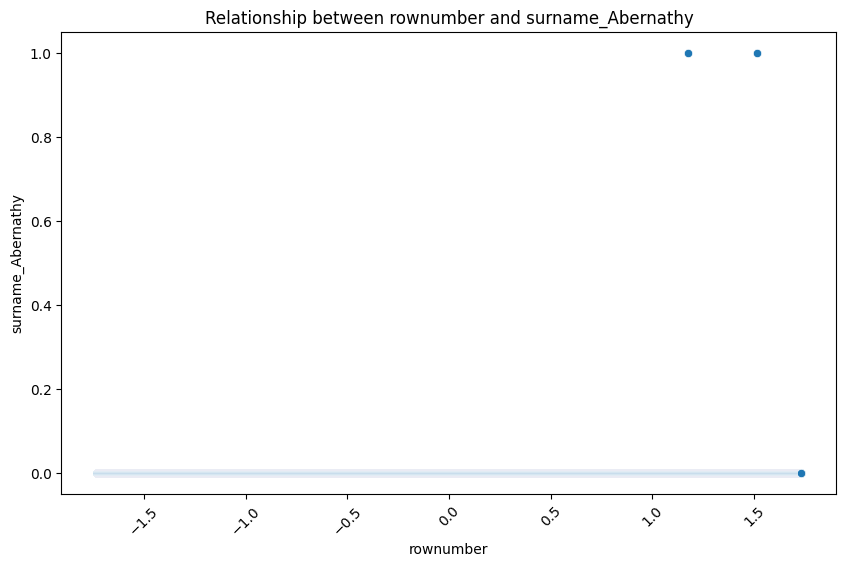

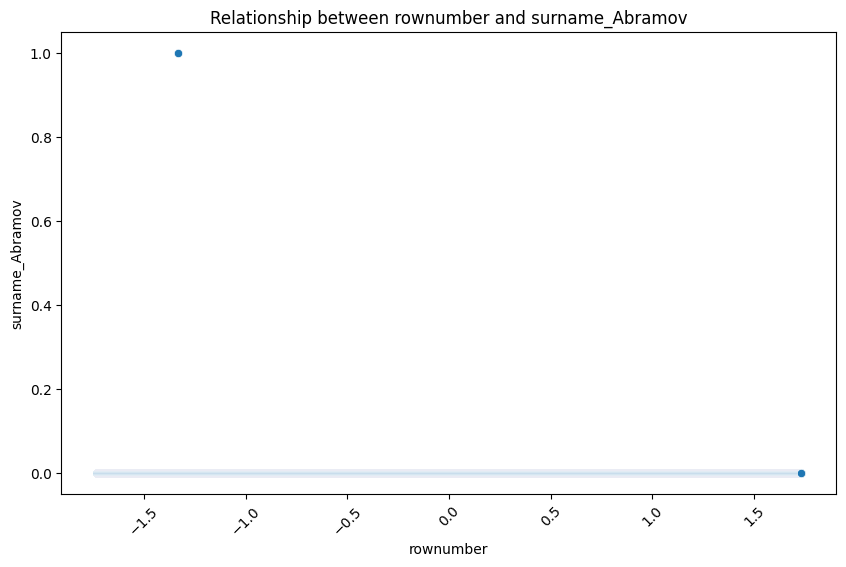

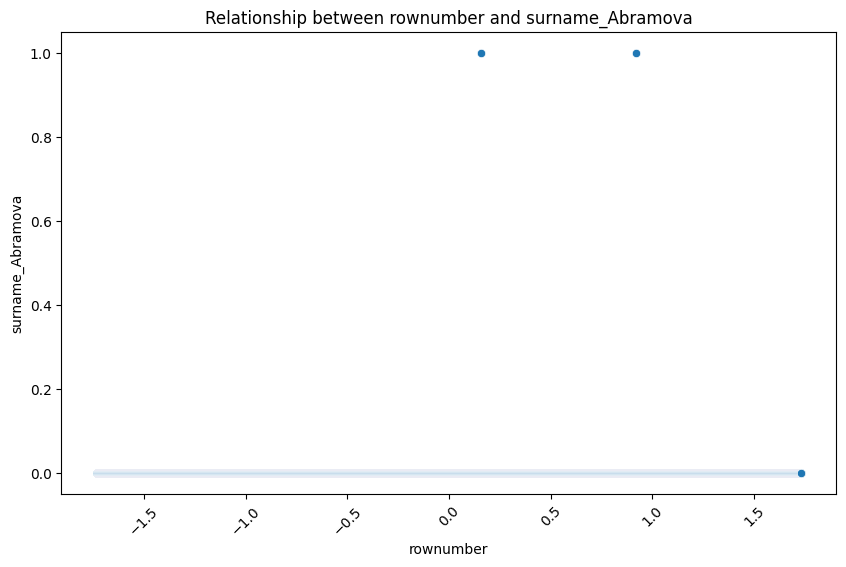

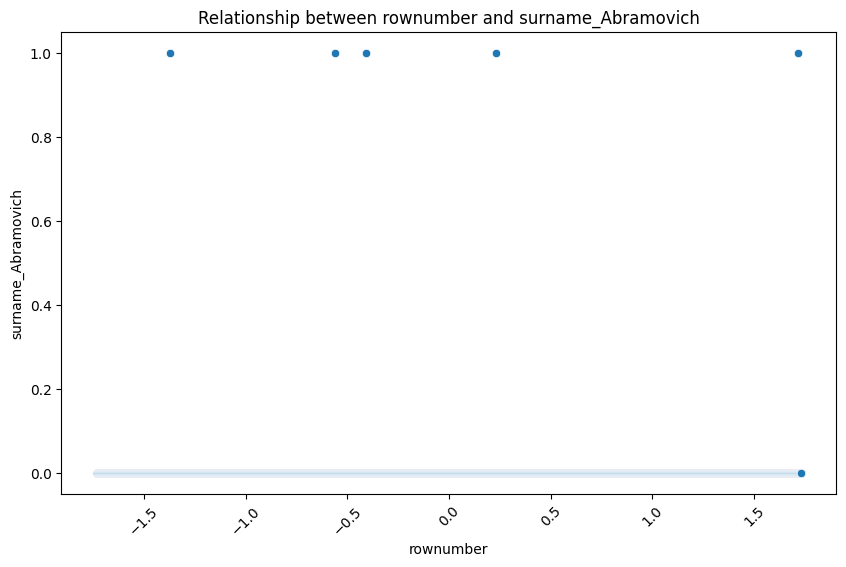

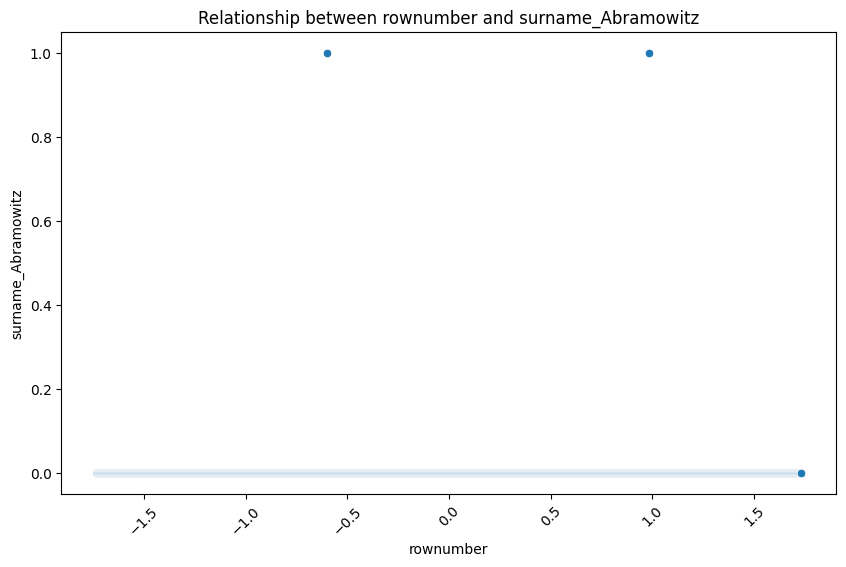

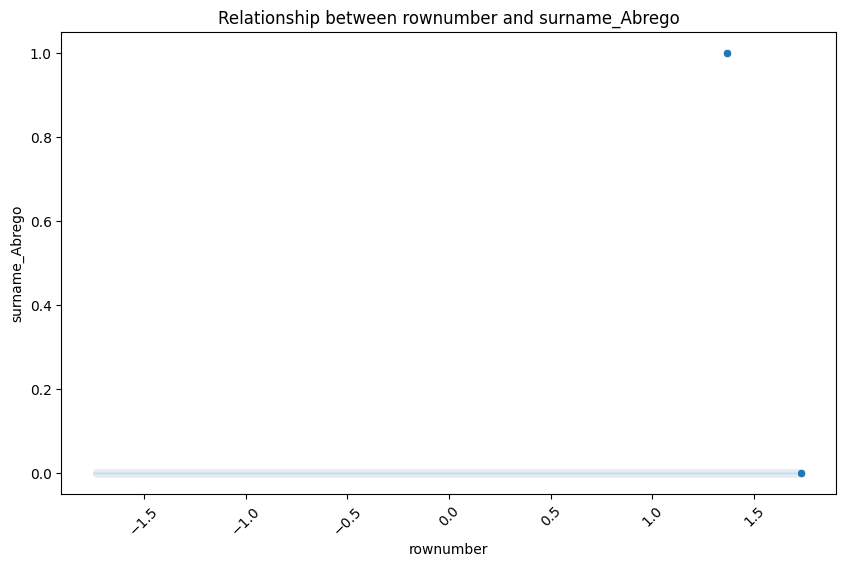

In [22]:
perform_eda(processed_data)